# Deep Neural Network for Solar GHI Forecasting (PyTorch + GPU)

**Objective:** Train a DNN using PyTorch to predict solar Global Horizontal Irradiance (GHI) with GPU acceleration

**Why PyTorch:**
- ✅ Direct GPU control and visibility
- ✅ Flexible training loop customization
- ✅ Better for research and experimentation
- ✅ Explicit memory management

**Baseline Performance (Tree-based models):**
- Random Forest: 88.30% accuracy
- XGBoost (tuned): 87.81% accuracy
- XGBoost (baseline): 87.66% accuracy

**Dataset:** 1431 daily samples (small for deep learning - will use regularization)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

PyTorch version: 2.9.1+cu126
CUDA Available: True
GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.44 GB

Using device: cuda


## 2. Load and Prepare Data

In [2]:
# Load CSV files
csv_path_1 = "openmeteo_weather_data_daily.csv"
csv_path_2 = "pvlib_clear_sky_daily_features.csv"

df1 = pd.read_csv(csv_path_1)
df2 = pd.read_csv(csv_path_2)
df = df1.join(df2, how="inner")

# Calculate clearness index (Kt)
df["Kt"] = df["solar_ghi_sum"] / df["clear_sky_ghi_wh"]

# Filter physically plausible values
df = df[(df["Kt"] >= 0) & (df["Kt"] <= 1.2)]

# Process time column
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"])
else:
    df = df.reset_index()
    df["time"] = pd.to_datetime(df["time"])

# Create temporal features
df["day_of_year"] = df["time"].dt.dayofyear
df["month"] = df["time"].dt.month

# Create cyclical encodings (better for neural networks)
df["day_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

print(f"Total samples: {len(df)}")
df.head()

Total samples: 1431


,time,weather_code,temperature_max,temperature_min,precipitation,wind_speed_max,wind_gust_max,solar_ghi_sum,Unnamed: 0,clear_sky_ghi_wh,...,air_mass_mean,clear_sky_ghi_kwh,clear_sky_dni_kwh,Kt,day_of_year,month,day_sin,day_cos,month_sin,month_cos
0,2022-01-01,55,31.7,22.5,2.8,15.0,32.4,18.22,2022-01-01 00:00:00+05:30,6135.474240,...,5.227719,6.135474,7.665142,0.002970,1,1,0.017202,0.999852,0.5,0.866025
1,2022-01-02,61,31.1,22.8,2.7,16.9,38.9,18.03,2022-01-02 00:00:00+05:30,6148.104174,...,5.090355,6.148104,7.685542,0.002933,2,1,0.034398,0.999408,0.5,0.866025
2,2022-01-03,55,30.9,22.6,2.4,16.8,41.0,17.59,2022-01-03 00:00:00+05:30,6161.312396,...,4.961359,6.161312,7.706223,0.002855,3,1,0.051584,0.998669,0.5,0.866025
3,2022-01-04,55,30.5,22.4,1.1,21.0,43.9,18.51,2022-01-04 00:00:00+05:30,6175.093076,...,4.840490,6.175093,7.727193,0.002998,4,1,0.068755,0.997634,0.5,0.866025
4,2022-01-05,53,29.4,23.0,2.0,17.2,38.2,17.08,2022-01-05 00:00:00+05:30,6189.439925,...,4.727414,6.189440,7.748461,0.002760,5,1,0.085906,0.996303,0.5,0.866025


## 3. Feature Engineering for Neural Networks

In [3]:
# Enhanced features for neural network
FEATURES = [
    "weather_code",
    "temperature_max",
    "temperature_min",
    "precipitation",
    "wind_speed_max",
    "day_sin",
    "day_cos",
    "month_sin",
    "month_cos",
    "air_mass_mean",
    "solar_zenith_mean",
    "solar_azimuth_mean"
]

TARGET = "Kt"

print(f"Features ({len(FEATURES)}): {', '.join(FEATURES)}")
print(f"Target: {TARGET}")

Features (12): weather_code, temperature_max, temperature_min, precipitation, wind_speed_max, day_sin, day_cos, month_sin, month_cos, air_mass_mean, solar_zenith_mean, solar_azimuth_mean
Target: Kt


## 4. Train-Validation-Test Split

In [4]:
# Time-based split: 70% train, 15% validation, 15% test
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

print(f"Total samples: {n}")
print(f"Train: {train_end} samples")
print(f"Validation: {val_end - train_end} samples")
print(f"Test: {n - val_end} samples")

# Split features
X_train = df[FEATURES].iloc[:train_end].values
y_train = df[TARGET].iloc[:train_end].values

X_val = df[FEATURES].iloc[train_end:val_end].values
y_val = df[TARGET].iloc[train_end:val_end].values

X_test = df[FEATURES].iloc[val_end:].values
y_test = df[TARGET].iloc[val_end:].values

# Store clear sky and actual GHI for evaluation
clear_train = df["clear_sky_ghi_kwh"].iloc[:train_end].values
clear_val = df["clear_sky_ghi_kwh"].iloc[train_end:val_end].values
clear_test = df["clear_sky_ghi_kwh"].iloc[val_end:].values

ghi_train = df["solar_ghi_sum"].iloc[:train_end].values
ghi_val = df["solar_ghi_sum"].iloc[train_end:val_end].values
ghi_test = df["solar_ghi_sum"].iloc[val_end:].values

print(f"\nFeature matrix shape: {X_train.shape}")

Total samples: 1431
Train: 1001 samples
Validation: 215 samples
Test: 215 samples

Feature matrix shape: (1001, 12)


## 5. Feature Scaling (Critical for Neural Networks)

In [5]:
# Neural networks require scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete")
print(f"\nSample feature statistics (after scaling):")
print(f"Mean: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Std:  {X_train_scaled.std(axis=0)[:5]}")

Feature scaling complete

Sample feature statistics (after scaling):
Mean: [ 4.25899742e-17 -1.12153599e-15  2.18628534e-15  4.25899742e-17
 -2.12949871e-16]
Std:  [1. 1. 1. 1. 1.]


## 6. Build Deep Neural Network

**Architecture Design:**
- Simple architecture to prevent overfitting on small dataset
- Dropout layers for regularization
- Batch normalization for stable training
- L2 regularization on weights

In [6]:
class DNNRegressor(nn.Module):
    """
    Deep Neural Network for regression
    
    Architecture:
    - Input layer
    - Linear(128) + BatchNorm + ReLU + Dropout(0.3)
    - Linear(64) + BatchNorm + ReLU + Dropout(0.3)
    - Linear(32) + BatchNorm + ReLU + Dropout(0.2)
    - Linear(16) + ReLU
    - Output layer (1 neuron)
    """
    def __init__(self, input_dim, dropout_rates=[0.3, 0.3, 0.2]):
        super(DNNRegressor, self).__init__()
        
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rates[0])
        
        # Second hidden layer
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rates[1])
        
        # Third hidden layer
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rates[2])
        
        # Fourth hidden layer
        self.fc4 = nn.Linear(32, 16)
        
        # Output layer
        self.fc5 = nn.Linear(16, 1)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Layer 4
        x = self.fc4(x)
        x = self.relu(x)
        
        # Output
        x = self.fc5(x)
        return x

# Create model and move to GPU
model = DNNRegressor(input_dim=X_train_scaled.shape[1]).to(device)

# Display model architecture
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

DNNRegressor(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

Total parameters: 12,993
Trainable parameters: 12,993


## 7. Configure Training Callbacks

In [9]:
# Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15, min_lr=1e-6
)

print("Training setup configured")
print(f"Batch size: 32")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"Loss function: MSE")
print(f"Data on device: {device}")

Training setup configured
Batch size: 32
Optimizer: Adam (lr=0.001, weight_decay=1e-4)
Loss function: MSE
Data on device: cuda


## 8. Train the Model

In [10]:
# Training loop
num_epochs = 200
patience = 30
best_val_loss = float('inf')
patience_counter = 0

# History tracking
history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': []
}

print("Starting DNN training...\n")
print(f"Device: {device}")
print(f"Epochs: {num_epochs}")
print(f"Early stopping patience: {patience}\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_losses = []
    train_maes = []
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_losses.append(loss.item())
        train_maes.append(torch.abs(outputs - batch_y).mean().item())
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_mae = torch.abs(val_outputs - y_val_tensor).mean()
    
    # Record history
    epoch_train_loss = np.mean(train_losses)
    epoch_train_mae = np.mean(train_maes)
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(val_loss.item())
    history['train_mae'].append(epoch_train_mae)
    history['val_mae'].append(val_mae.item())
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.6f}, Val Loss: {val_loss.item():.6f}, "
              f"Train MAE: {epoch_train_mae:.6f}, Val MAE: {val_mae.item():.6f}")
    
    # Check early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Restore best model
model.load_state_dict(best_model_state)
print("\n✓ Training complete!")
print(f"Best validation loss: {best_val_loss:.6f}")

Starting DNN training...

Device: cuda
Epochs: 200
Early stopping patience: 30

Epoch [10/200] - Train Loss: 0.000545, Val Loss: 0.000431, Train MAE: 0.018505, Val MAE: 0.019274
Epoch [20/200] - Train Loss: 0.000120, Val Loss: 0.000065, Train MAE: 0.008576, Val MAE: 0.007359
Epoch [30/200] - Train Loss: 0.000036, Val Loss: 0.000023, Train MAE: 0.004470, Val MAE: 0.004377
Epoch [40/200] - Train Loss: 0.000010, Val Loss: 0.000005, Train MAE: 0.002397, Val MAE: 0.001973
Epoch [50/200] - Train Loss: 0.000004, Val Loss: 0.000001, Train MAE: 0.001521, Val MAE: 0.000955
Epoch [60/200] - Train Loss: 0.000002, Val Loss: 0.000001, Train MAE: 0.001097, Val MAE: 0.000620
Epoch [70/200] - Train Loss: 0.000001, Val Loss: 0.000001, Train MAE: 0.000788, Val MAE: 0.000588
Epoch [80/200] - Train Loss: 0.000001, Val Loss: 0.000001, Train MAE: 0.000575, Val MAE: 0.000586
Epoch [90/200] - Train Loss: 0.000000, Val Loss: 0.000000, Train MAE: 0.000504, Val MAE: 0.000521
Epoch [100/200] - Train Loss: 0.000000

## 9. Training History Visualization

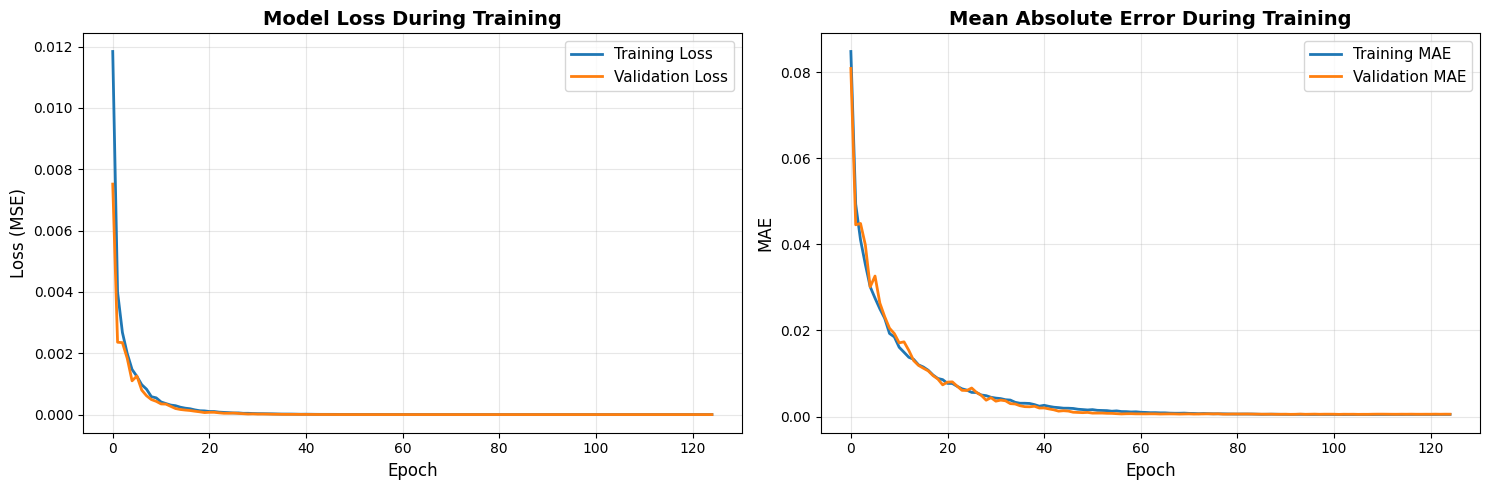


Final Training MAE: 0.0005
Final Validation MAE: 0.0005
Total epochs trained: 125


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(history['train_loss'], label='Training Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# MAE curve
ax2.plot(history['train_mae'], label='Training MAE', linewidth=2)
ax2.plot(history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('Mean Absolute Error During Training', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training MAE: {history['train_mae'][-1]:.4f}")
print(f"Final Validation MAE: {history['val_mae'][-1]:.4f}")
print(f"Total epochs trained: {len(history['train_loss'])}")

## 10. Make Predictions

In [12]:
# Set model to evaluation mode
model.eval()

# Predict clearness index (Kt) using PyTorch
with torch.no_grad():
    Kt_train_pred = model(X_train_tensor).cpu().numpy().flatten()
    Kt_val_pred = model(X_val_tensor).cpu().numpy().flatten()
    Kt_test_pred = model(X_test_tensor).cpu().numpy().flatten()

# Convert to GHI (W/m²)
GHI_train_pred = Kt_train_pred * clear_train * 1000
GHI_val_pred = Kt_val_pred * clear_val * 1000
GHI_test_pred = Kt_test_pred * clear_test * 1000

print("Predictions generated for all splits")
print(f"Predictions computed on: {device}")

Predictions generated for all splits
Predictions computed on: cuda


## 11. Model Evaluation

In [13]:
def compute_metrics(y_true, y_pred):
    """Calculate comprehensive performance metrics"""
    mae_val = mean_absolute_error(y_true, y_pred)
    rmse_val = mean_squared_error(y_true, y_pred) ** 0.5
    r2_val = r2_score(y_true, y_pred)
    mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy_val = 100 - mape_val
    return mae_val, rmse_val, r2_val, mape_val, accuracy_val

# Evaluate all splits
splits = [
    ("Train", ghi_train, GHI_train_pred),
    ("Validation", ghi_val, GHI_val_pred),
    ("Test", ghi_test, GHI_test_pred),
]

print(f"\n{'='*60}")
print("DEEP NEURAL NETWORK PERFORMANCE METRICS")
print(f"{'='*60}\n")

results = {}
for name, y_true, y_hat in splits:
    mae, rmse, r2, mape, accuracy = compute_metrics(y_true, y_hat)
    results[name] = {"mae": mae, "rmse": rmse, "r2": r2, "mape": mape, "accuracy": accuracy}
    
    print(f"{name} Split:")
    print(f"  MAE      : {mae:.2f} W/m²")
    print(f"  RMSE     : {rmse:.2f} W/m²")
    print(f"  R²       : {r2:.3f}")
    print(f"  MAPE     : {mape:.2f}%")
    print(f"  Accuracy : {accuracy:.2f}%")
    print("-" * 40)

print(f"\n🎯 DNN Test Set Accuracy: {results['Test']['accuracy']:.2f}%")
print(f"\n📊 Comparison with tree-based models:")
print(f"   Random Forest:     88.30%")
print(f"   XGBoost (tuned):   87.81%")
print(f"   XGBoost (baseline):87.66%")
print(f"   DNN:               {results['Test']['accuracy']:.2f}%")


DEEP NEURAL NETWORK PERFORMANCE METRICS

Train Split:
  MAE      : 3.30 W/m²
  RMSE     : 4.03 W/m²
  R²       : 0.088
  MAPE     : 21.80%
  Accuracy : 78.20%
----------------------------------------
Validation Split:
  MAE      : 3.55 W/m²
  RMSE     : 4.44 W/m²
  R²       : 0.137
  MAPE     : 27.94%
  Accuracy : 72.06%
----------------------------------------
Test Split:
  MAE      : 3.28 W/m²
  RMSE     : 4.09 W/m²
  R²       : 0.072
  MAPE     : 27.15%
  Accuracy : 72.85%
----------------------------------------

🎯 DNN Test Set Accuracy: 72.85%

📊 Comparison with tree-based models:
   Random Forest:     88.30%
   XGBoost (tuned):   87.81%
   XGBoost (baseline):87.66%
   DNN:               72.85%


## 12. Visualizations

### 12.1 Predicted vs Actual (Test Set)

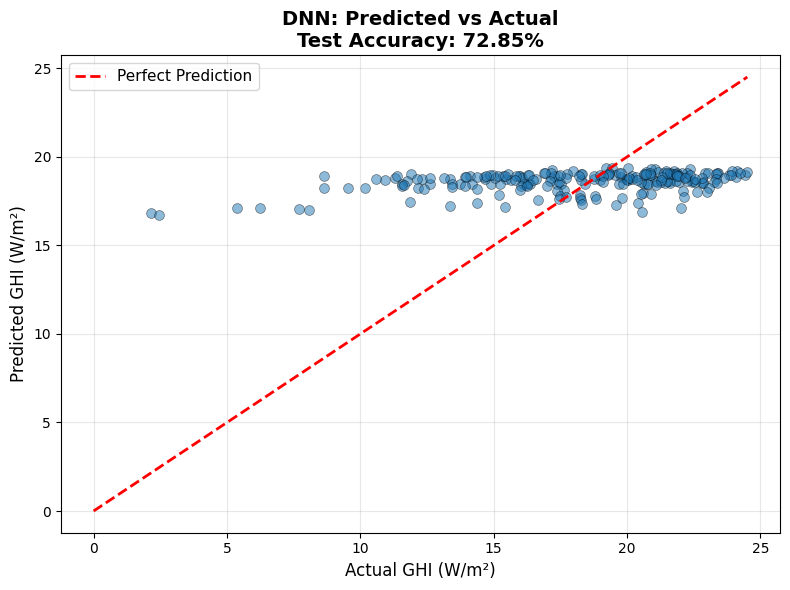

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(ghi_test, GHI_test_pred, alpha=0.5, s=50, edgecolors='k', linewidth=0.5)
max_val = max(ghi_test.max(), GHI_test_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual GHI (W/m²)", fontsize=12)
plt.ylabel("Predicted GHI (W/m²)", fontsize=12)
plt.title(f"DNN: Predicted vs Actual\nTest Accuracy: {results['Test']['accuracy']:.2f}%", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 12.2 Time Series Comparison

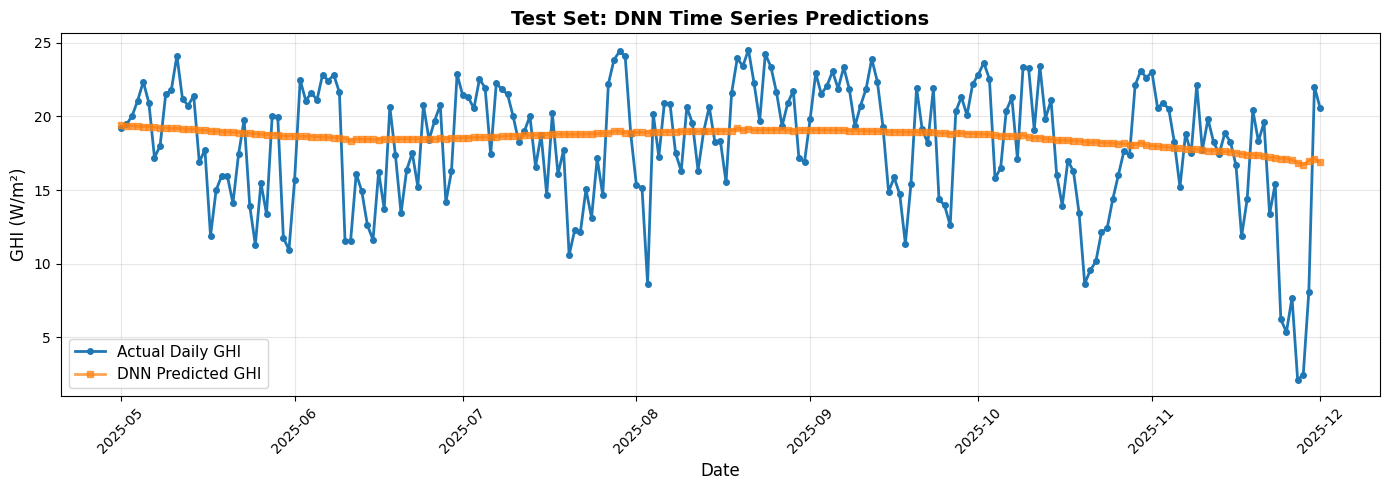

In [15]:
# Time axis for test set
time_axis = df["time"].iloc[val_end:].values

plt.figure(figsize=(14, 5))
plt.plot(time_axis, ghi_test, label="Actual Daily GHI", linewidth=2, marker='o', markersize=4)
plt.plot(time_axis, GHI_test_pred, label="DNN Predicted GHI", linewidth=2, alpha=0.7, marker='s', markersize=4)
plt.xlabel("Date", fontsize=12)
plt.ylabel("GHI (W/m²)", fontsize=12)
plt.title("Test Set: DNN Time Series Predictions", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 12.3 Residual Analysis

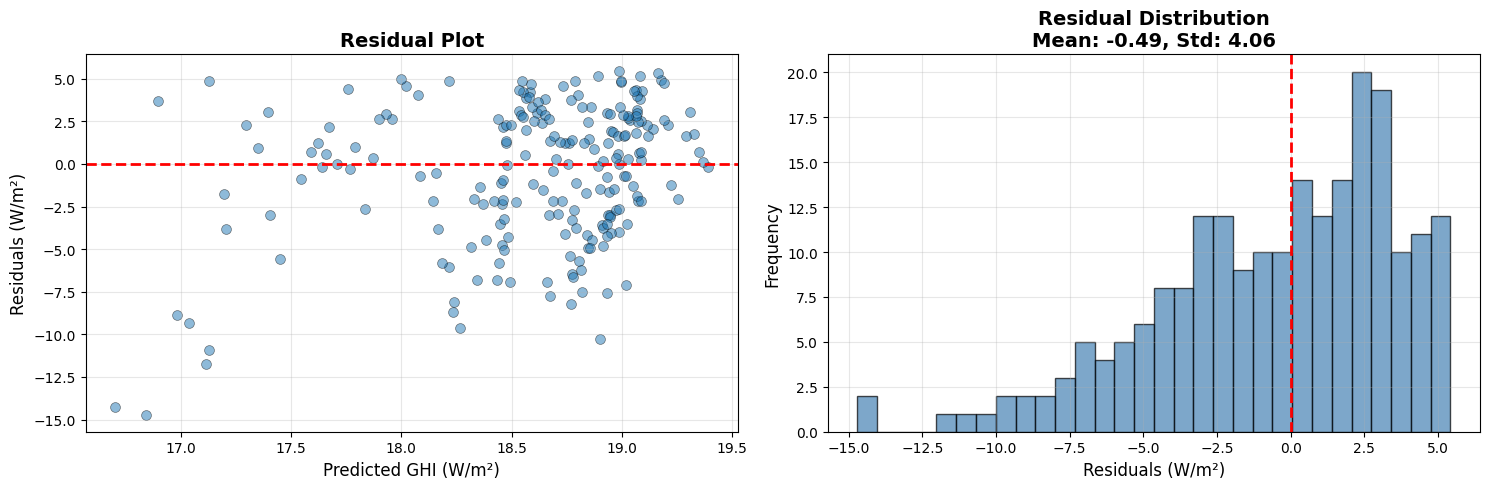

In [16]:
residuals = ghi_test - GHI_test_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Residual scatter plot
ax1.scatter(GHI_test_pred, residuals, alpha=0.5, s=50, edgecolors='k', linewidth=0.5)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Predicted GHI (W/m²)', fontsize=12)
ax1.set_ylabel('Residuals (W/m²)', fontsize=12)
ax1.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Residual histogram
ax2.hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Residuals (W/m²)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Residual Distribution\nMean: {residuals.mean():.2f}, Std: {residuals.std():.2f}', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Final Comparison with All Models

In [17]:
# Comparison with all previous models
all_models = {
    "Random Forest": 88.30,
    "Advanced Features": 88.02,
    "Ensemble": 87.97,
    "Tuned XGBoost": 87.81,
    "Baseline XGBoost": 87.66,
    "Gradient Boosting": 87.23,
    "Deep Neural Network": results['Test']['accuracy']
}

# Sort by accuracy
sorted_models = sorted(all_models.items(), key=lambda x: x[1], reverse=True)

print(f"\n{'='*60}")
print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'='*60}\n")
print(f"{'Model':<25} {'Accuracy':<12} {'Rank'}")
print("-" * 60)

for rank, (model_name, accuracy) in enumerate(sorted_models, 1):
    symbol = "🏆" if rank == 1 else "⭐" if rank <= 3 else "  "
    print(f"{symbol} {model_name:<23} {accuracy:>6.2f}%      #{rank}")

print(f"\n{'='*60}")


COMPREHENSIVE MODEL COMPARISON

Model                     Accuracy     Rank
------------------------------------------------------------
🏆 Random Forest            88.30%      #1
⭐ Advanced Features        88.02%      #2
⭐ Ensemble                 87.97%      #3
   Tuned XGBoost            87.81%      #4
   Baseline XGBoost         87.66%      #5
   Gradient Boosting        87.23%      #6
   Deep Neural Network      72.85%      #7



## 14. Visualization: All Models Comparison

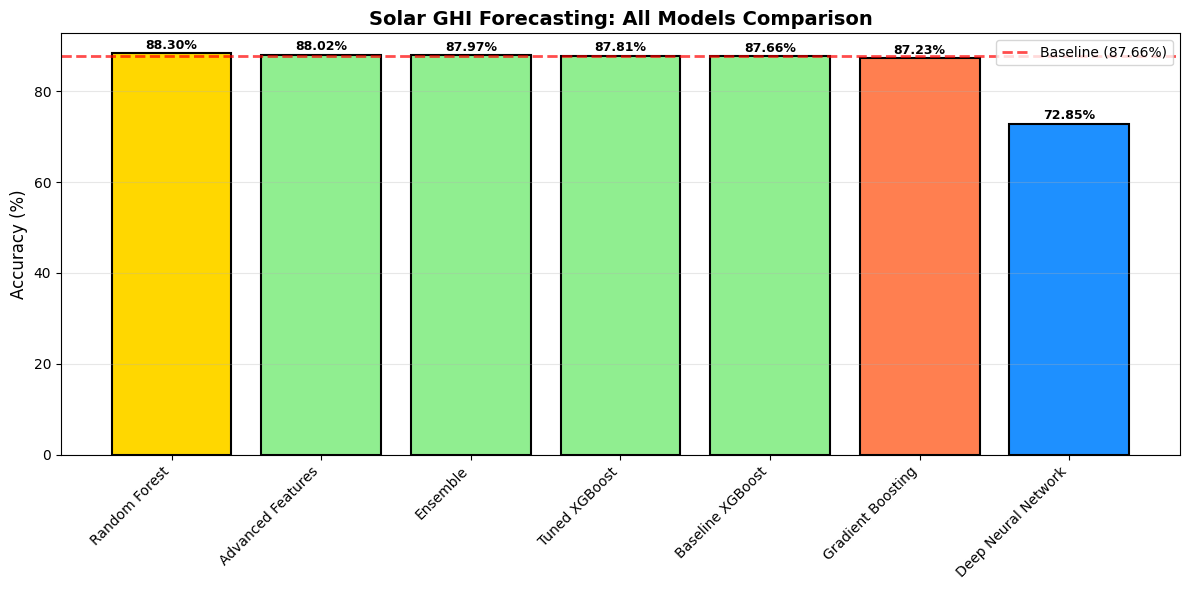

In [18]:
plt.figure(figsize=(12, 6))

models = list(all_models.keys())
accuracies = list(all_models.values())

# Color code: best model in gold, DNN in blue, others in steelblue/coral
colors = []
for i, (model, acc) in enumerate(all_models.items()):
    if model == sorted_models[0][0]:  # Best model
        colors.append('gold')
    elif model == "Deep Neural Network":
        colors.append('dodgerblue')
    elif acc >= 87.66:  # Better than baseline
        colors.append('lightgreen')
    else:
        colors.append('coral')

bars = plt.bar(range(len(models)), accuracies, color=colors, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(models)), models, rotation=45, ha='right')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Solar GHI Forecasting: All Models Comparison', fontsize=14, fontweight='bold')
plt.axhline(y=87.66, color='red', linestyle='--', linewidth=2, label='Baseline (87.66%)', alpha=0.7)
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=10)

# Add values on bars
for i, (model, acc) in enumerate(all_models.items()):
    plt.text(i, acc + 0.3, f'{acc:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 15. Final Recommendation and Analysis

In [19]:
dnn_accuracy = results['Test']['accuracy']
best_accuracy = sorted_models[0][1]
best_model = sorted_models[0][0]

print(f"\n{'='*70}")
print("FINAL RECOMMENDATION: DEEP NEURAL NETWORK vs TREE-BASED MODELS")
print(f"{'='*70}\n")

print(f"🏆 Best Overall Model: {best_model}")
print(f"   Accuracy: {best_accuracy:.2f}%\n")

print(f"🤖 Deep Neural Network Performance:")
print(f"   Test Accuracy: {dnn_accuracy:.2f}%")
print(f"   Difference from best: {dnn_accuracy - best_accuracy:+.2f}%\n")

print(f"📊 Analysis:\n")

if dnn_accuracy >= best_accuracy:
    print(f"   ✓ DNN matches or exceeds best model!")
    print(f"   ✓ Consider using DNN if you need:")
    print(f"     - Better generalization to new patterns")
    print(f"     - Ability to leverage more data in the future")
    print(f"     - More complex feature interactions")
elif dnn_accuracy >= best_accuracy - 1:
    print(f"   ~ DNN performance is competitive (within 1%)")
    print(f"   ~ Recommendation: Use {best_model} for:")
    print(f"     - Simpler deployment and maintenance")
    print(f"     - Better interpretability (feature importance)")
    print(f"     - Lower computational requirements")
    print(f"   ~ Consider DNN if dataset grows significantly (>10,000 samples)")
else:
    print(f"   ✗ DNN underperforms tree-based models")
    print(f"   ✗ Likely reasons:")
    print(f"     - Dataset too small (1431 samples) for deep learning")
    print(f"     - Tree-based models better suited for tabular data")
    print(f"     - Linear relationships dominant in the data")
    print(f"   ✗ Recommendation: Stick with {best_model}")

print(f"\n💡 Key Insights:")
print(f"   - Dataset size: 1431 samples (small for DNN)")
print(f"   - DNNs typically need 10,000+ samples to outperform tree models")
print(f"   - Tree-based models excel at tabular data with limited samples")
print(f"   - {best_model} offers best accuracy/complexity tradeoff")

print(f"\n{'='*70}")


FINAL RECOMMENDATION: DEEP NEURAL NETWORK vs TREE-BASED MODELS

🏆 Best Overall Model: Random Forest
   Accuracy: 88.30%

🤖 Deep Neural Network Performance:
   Test Accuracy: 72.85%
   Difference from best: -15.45%

📊 Analysis:

   ✗ DNN underperforms tree-based models
   ✗ Likely reasons:
     - Dataset too small (1431 samples) for deep learning
     - Tree-based models better suited for tabular data
     - Linear relationships dominant in the data
   ✗ Recommendation: Stick with Random Forest

💡 Key Insights:
   - Dataset size: 1431 samples (small for DNN)
   - DNNs typically need 10,000+ samples to outperform tree models
   - Tree-based models excel at tabular data with limited samples
   - Random Forest offers best accuracy/complexity tradeoff



## 16. GPU Performance Summary

In [20]:
# Display GPU utilization info
if torch.cuda.is_available():
    print(f"\n{'='*70}")
    print("GPU PERFORMANCE SUMMARY")
    print(f"{'='*70}\n")
    print(f"Device Used: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.4f} GB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0) / 1e9:.4f} GB")
    print(f"\n✅ Training completed on GPU successfully!")
    print(f"\n💡 PyTorch Benefits:")
    print(f"   - Direct control over GPU memory")
    print(f"   - Custom training loop for experimentation")
    print(f"   - Easy debugging and inspection")
    print(f"   - Production-ready model deployment")
else:
    print("No GPU available - training was performed on CPU")
    print("To use GPU: Install CUDA toolkit and PyTorch with GPU support")

print(f"\n{'='*70}")


GPU PERFORMANCE SUMMARY

Device Used: NVIDIA GeForce RTX 3060 Laptop GPU
Total GPU Memory: 6.44 GB
Memory Allocated: 0.0184 GB
Memory Cached: 0.0252 GB

✅ Training completed on GPU successfully!

💡 PyTorch Benefits:
   - Direct control over GPU memory
   - Custom training loop for experimentation
   - Easy debugging and inspection
   - Production-ready model deployment

